# Off-targeting analysis

© 2023 Eligo Bioscience

#### Dependencies
- bakta 1.8.2
- biopython 1.81
- breseq 0.37.1
- bwa 0.7.17-r1188
- fastp v0.23.2
- matplotlib 3.6.2
- pandas 1.5.2
- parallel 20221122
- pyarrow 10.0.1
- pysam v0.20.0
- python 3.10.8
- samtools 1.16.1
- scipy 1.9.3
- seaborn 0.12.1
- seqkit v2.3.0
- spades 3.15.5

In [1]:
%cd data/offtargeting

/Users/simone/git/in-situ-targeted-mutagenesis-of-gut-bacteria/data/offtargeting


In [ ]:
%%bash

mkdir reads qc breseq ref aln merged
# Raw reads downloaded to the reads directory

# Basic QC with fastp
cd reads
find . -name '*_1.fastq.gz' | parallel -j 8 --plus 'fastp -i {} -I {%_1.fastq.gz}_2.fastq.gz -o ../qc/{/} -O ../qc/`basename {%_1.fastq.gz}`_2.fastq.gz --json ../qc/{%_1.fastq.gz}.json --html ../qc/{%_1.fastq.gz}.html --report_title "{%_1.fastq.gz}" --length_required 50 --thread 16'
# Merge all sequencing libraries for each sample
# The resulting merged readsets have been uploaded to SRA (BioProject PRJNA944658)
cd ../merged
find ../qc -name '*.html' | parallel -j 1 'echo {/.} | cut -d _ -f 1-3' | sort -u | parallel -j 1 'l=../qc/{}_*_1.fastq.gz && cat $l > {}_1.fastq.gz && cat `echo $l | sed "s/_1.fastq.gz/_2.fastq.gz/g"` > {}_2.fastq.gz'

# Use breseq to update the MG1655 reference genome with the modifications introduced in the strain before the experiment
# The first repeat of the control sample (MG1655_Control_S1) was used for this purpose
cd ../breseq
breseq -n MG -j 128 --limit-fold-coverage 120 -r MG1655_WT.gbk ../merged/MG1655_Control_S1_1.fastq.gz ../merged/MG1655_Control_S1_2.fastq.gz
gdtools APPLY -o ../ref/MG1655.fna -f fasta -r MG1655_WT.gbk output/output.gd

# Align merged readsets
cd ../reads
find . -name '*_1.fastq.gz' | grep -v 'J23' | parallel -j8 --plus --rpl '%% s:^./::;s:_1.fastq.gz$::;' 'bwa mem -t 16 ../ref/`echo %% | cut -d _ -f 1`.fna {/} %%_2.fastq.gz | samtools view --threads 2 --uncompressed | samtools sort --threads 4 -l 7 -o ../aln/%%.bam && samtools index ../aln/%%.bam'

In [ ]:
%%bash

# Annotate reference genomes
cd ref
bakta --db ../bakta_db_20231011/db --prefix MG1655 --locus MG1655 --output MG1655 --genus Escherichia --species coli --strain MG1655 --complete --threads 12 MG1655.fna
bakta --db ../bakta_db_20231011/db --prefix TN03 --locus TN03 --output TN03 --genus Escherichia --species coli --strain TN03 --complete --threads 12 TN03.fna

# Find potential offtargets (up to 7 mismatches to guide) in the reference genomes
# N counts as a mismatch, so -m 8 = 7 mismatches in the guide
cd ..
seqkit locate -i -j 8 -m 8 -p 'GTTTCATGTAAAACCCCCATNGG' ref/TN03.fna > ref/TN03_offtargets_m7.bed
seqkit locate -i -j 8 -m 8 -p 'ACTTTTAAAGTTCTGCTATGNGG' ref/MG1655.fna > ref/MG1655_offtargets_m7.bed

In [2]:
import csv
import math
import pysam
import logging
import itertools
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp

from collections import Counter
from operator import itemgetter
from bisect import bisect, insort

ALN_DIR = 'aln'
REF_DIR = 'ref'
PILEUP_DIR = 'pileups'
PLOTS_DIR = 'plots'
NT_BASES = ['A', 'C', 'G', 'T']

samples = ['TN03', 'MG1655']
exp_conditions = ['Control', 'ABE']
exp_repeats = ['S1', 'S2']

rev_comp = {
    'A': 'T',
    'C': 'G',
    'T': 'A',
    'G': 'C',
}

colors_dict = {
    ('Control', 'S1'): (90/255, 181/255, 242/255),
    ('Control', 'S2'): (90/255, 100/255, 242/255),
    ('ABE', 'S1'): (242/255, 148/255, 90/255),
    ('ABE', 'S2'): (191/255, 43/255, 23/255),
}

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [ ]:
# Compute read alignment pileups and store them in gzipped parquet format
# Counts variants of each nucleotide across the whole reference genome based on read alignment pileup
def process_bam(aln_fn, ref_fn, out_fn):
    var_counter = []
    with pysam.FastaFile(ref_fn) as ref:
        with pysam.AlignmentFile(aln_fn, "rb") as aln_f:
            for pileupcolumn in aln_f.pileup(stepper='all', max_depth=50000, fastafile=ref):
                pileup = pileupcolumn.get_query_sequences()
                pileup_counter = dict(Counter([s.upper() for s in pileup]))
                pileup_counter['ref_id'] = pileupcolumn.reference_id
                pileup_counter['ref_pos'] = pileupcolumn.reference_pos
                pileup_counter['ref_nt'] = ref[pileupcolumn.reference_name][pileupcolumn.reference_pos].upper()
                var_counter.append(pileup_counter)
                if pileupcolumn.reference_pos % 100000 == 0:
                    logging.info(f"{aln_fn}: {pileupcolumn.reference_pos}")
    df = pd.DataFrame(var_counter)
    df.to_parquet(out_fn, compression='gzip')
    return [out_fn.split('/')[-1].split('.')[0]] + sorted(list(df.columns))


with mp.Pool(mp.cpu_count()) as pool:
    results = pool.starmap(
        process_bam,
        [(f"{ALN_DIR}/{s[0]}_{s[1]}_{s[2]}.bam", f"{REF_DIR}/{s[0]}.fna", f"{PILEUP_DIR}/{s[0]}_{s[1]}_{s[2]}.parquet.gzip") for s in itertools.product(samples, exp_conditions, exp_repeats)]
    )

In [ ]:
COLUMN_ASINT = {nt: 'int64' for nt in NT_BASES}
COLUMN_ASINT['cov'] = 'int64'

def _log10_mut_freq(row):
    return math.log10(row['cov']-row[row['ref_nt']]+1)-math.log10(row['cov']+1)

sample_ids = list(itertools.product(samples, exp_conditions, exp_repeats))

df_dict = {}

# Compute log10 mutation frequency for each position
for sample, cond, rep in sample_ids:
    df = pd.read_parquet(f"{PILEUP_DIR}/{sample}_{cond}_{rep}.parquet.gzip")
    df = df.drop(columns=[''], errors='ignore').fillna(0)
    df = df.assign(cov=df[NT_BASES].sum(axis=1))
    df = df.assign(log10_mut_freq=df.apply(lambda row: _log10_mut_freq(row), axis=1))
    df_dict[(sample, cond, rep)] = df.astype(COLUMN_ASINT)

# Merge all conditions and repeats in a single DF
for sample in samples:
    sample_ids = list(itertools.product([sample], exp_conditions, exp_repeats))
    merged_df = df_dict[sample_ids[0]]
    for s_id in sample_ids[1:]:
        merged_df = pd.merge(
            merged_df, df_dict[s_id], how='outer',
            on=['ref_id', 'ref_pos', 'ref_nt'],
            suffixes=('', f'_{s_id[1]}_{s_id[2]}')
        )
    sfx = f'_{sample_ids[0][1]}_{sample_ids[0][2]}'
    merged_df = merged_df\
        .rename(columns={"A": "A"+sfx, "C": "C"+sfx, "G": "G"+sfx, "T": "T"+sfx, "cov": "cov"+sfx, "log10_mut_freq": "log10_mut_freq"+sfx})\
        .sort_values(by=['ref_id', 'ref_pos'])
    merged_df.to_parquet(f"{PILEUP_DIR}/{sample}.parquet.gzip", compression='gzip')

In [3]:
merged_df_dict = {}
for sample in samples:
    merged_df_dict[sample] = pd.read_parquet(f"{PILEUP_DIR}/{sample}.parquet.gzip")

In [4]:
def find_genes(gff_file, bed_file):
    # Helper function to sort features by contig and start position
    by_start = itemgetter('seqID', 'start')

    # Read the GFF file
    sorted_feature_list = []
    with open(gff_file, "r") as in_f:
        reader = csv.DictReader(in_f, delimiter="\t", fieldnames=['seqID', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
        for row in reader:
            if row['seqID'].startswith('##FASTA'):
                break
            # skip comments and genes (duplicates for CDS)
            elif row['seqID'].startswith('#') or row['type'] == 'gene':
                continue
            try:
                attributes = row['attributes'].split(';')
            except AttributeError:
                attributes = []
            feature_id = None
            product = None
            gene = None
            for attr in attributes:
                if attr.startswith('ID='):
                    feature_id = attr[3:]
                elif attr.startswith('product='):
                    product = attr[8:]
                elif attr.startswith('gene='):
                    gene = attr[5:]
            feat = {'seqID': row['seqID'], 'type': row['type'], 'start': int(row['start']), 'end': int(row['end']), 'strand': row['strand'], 'feature_id': feature_id, 'product': product, 'gene': gene}
            # insert in sorted list (by contig and start position) without breaking the sort
            insort(sorted_feature_list, feat, key=by_start)

    # Read the BED file
    sorted_bed_locations = []
    with open(bed_file, "r") as in_f:
        reader = csv.DictReader(in_f, delimiter="\t")
        for row in reader:
            feat = {'seqID': row['seqID'], 'start': int(row['start']), 'end': int(row['end']), 'strand': row['strand'], 'target': row['pattern'].upper(), 'matched': row['matched'].upper()}
            # Filter out candidates with mismatches in PAM or with >2 mismatches in the 10 PAM-proximal nucleotides
            # Bed files generated with `seqkit locate -i -m 8 -p '{TARGET_SEQ}' ref.fna > offtargets_m7.bed`
            # N counts as a mismatch (and there is one in the PAM), so -m 8 = 7 mismatches in the guide
            if feat['matched'][-2:] != 'GG' or sum(p!=m for p, m in zip(feat['target'][10:20], feat['matched'][10:20])) > 2:
                continue
            insort(sorted_bed_locations, feat, key=by_start)

    correspondance_table = []
    offtarget_id = 1
    empty_feature = {'seqID': None, 'type': None, 'start': None, 'end': None, 'strand': None, 'feature_id': None, 'product': None, 'gene': None}
    # Find the genes corresponding to the BED entry and the ones immediately before and after
    for bed_entry in sorted_bed_locations:
        # find the index of the first feature that starts after the bed entry
        feat_p1_idx = bisect(sorted_feature_list, (bed_entry['seqID'], bed_entry['start']), key=by_start)
        feat_0 = sorted_feature_list[feat_p1_idx-1]
        if feat_0['start'] < bed_entry['end'] and feat_0['end'] > bed_entry['start']:
            # gff feature overlaps with bed entry (ignore strand)
            feat_m1 = sorted_feature_list[feat_p1_idx-2] if sorted_feature_list[feat_p1_idx-2]['seqID'] == bed_entry['seqID'] else empty_feature
            feat_p1 = sorted_feature_list[feat_p1_idx] if sorted_feature_list[feat_p1_idx]['seqID'] == bed_entry['seqID'] else empty_feature
        else:
            # bed entry is in intergenic region
            feat_m1 = feat_0 if feat_0['seqID'] == bed_entry['seqID'] else empty_feature
            feat_0 = empty_feature
            feat_p1 = sorted_feature_list[feat_p1_idx] if sorted_feature_list[feat_p1_idx]['seqID'] == bed_entry['seqID'] else empty_feature

        if bed_entry['target'][:-3] == bed_entry['matched'][:-3]:
            correspondance_table.insert(0, [
                0, bed_entry['seqID'], bed_entry['start'], bed_entry['end'], bed_entry['strand'], bed_entry['target'], bed_entry['matched'],
                feat_0['type'], feat_0['start'], feat_0['end'], feat_0['strand'], feat_0['feature_id'], feat_0['product'], feat_0['gene'],
                feat_m1['type'], feat_m1['start'], feat_m1['end'], feat_m1['strand'], feat_m1['feature_id'], feat_m1['product'], feat_m1['gene'],
                feat_p1['type'], feat_p1['start'], feat_p1['end'], feat_p1['strand'], feat_p1['feature_id'], feat_p1['product'], feat_p1['gene']
            ])
        else:
            correspondance_table.append([
                offtarget_id, bed_entry['seqID'], bed_entry['start'], bed_entry['end'], bed_entry['strand'], bed_entry['target'], bed_entry['matched'],
                feat_0['type'], feat_0['start'], feat_0['end'], feat_0['strand'], feat_0['feature_id'], feat_0['product'], feat_0['gene'],
                feat_m1['type'], feat_m1['start'], feat_m1['end'], feat_m1['strand'], feat_m1['feature_id'], feat_m1['product'], feat_m1['gene'],
                feat_p1['type'], feat_p1['start'], feat_p1['end'], feat_p1['strand'], feat_p1['feature_id'], feat_p1['product'], feat_p1['gene']
            ])
            offtarget_id += 1

    df = pd.DataFrame(correspondance_table, columns=[
        'offtarget_id', 'contig', 'start', 'end', 'strand', 'target', 'matched',
        'gene_type', 'gene_start', 'gene_end', 'gene_strand', 'gene_id', 'gene_product', 'gene_name',
        'type_-1', 'start_-1', 'end_-1', 'strand_-1', 'id_-1', 'product_-1', 'gene_-1',
        'type_+1', 'start_+1', 'end_+1', 'strand_+1', 'id_+1', 'product_+1', 'gene_+1'
    ])
    # Can be float because of NaN values, cast it to nullable integer
    COLUMN_ASINT = {c: 'Int64' for c in ['start', 'end', 'gene_start', 'gene_end', 'start_-1', 'end_-1', 'start_+1', 'end_+1']}
    df = df.astype(COLUMN_ASINT)
    return df

offtarget_df_dict = {
    'TN03': find_genes("{REF_DIR}/TN03/TN03.gff3", "{REF_DIR}/TN03_offtargets_m7.bed"),
    'MG1655': find_genes("{REF_DIR}/MG1655/MG1655.gff3", "{REF_DIR}/MG1655_offtargets_m7.bed")
}
for sample, offtarget_df in offtarget_df_dict.items():
    offtarget_df.to_csv(f"{REF_DIR}/{sample}_offtargets_table.csv", index=False)

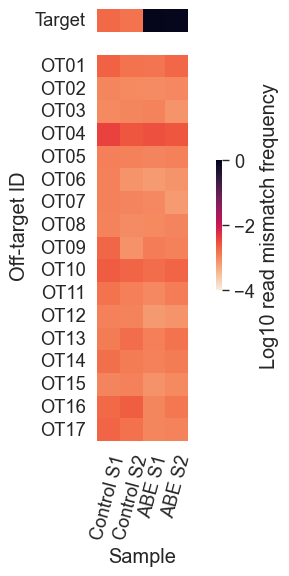

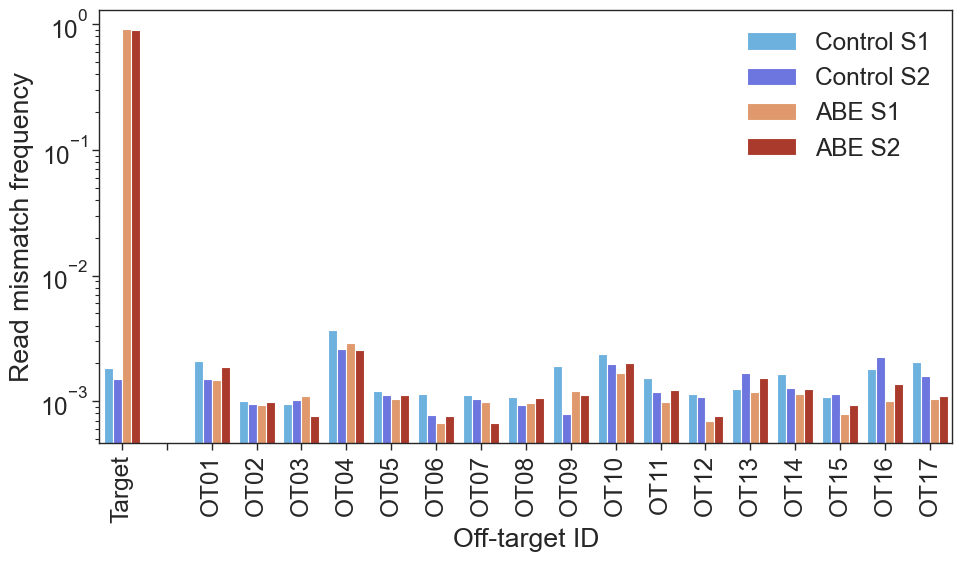

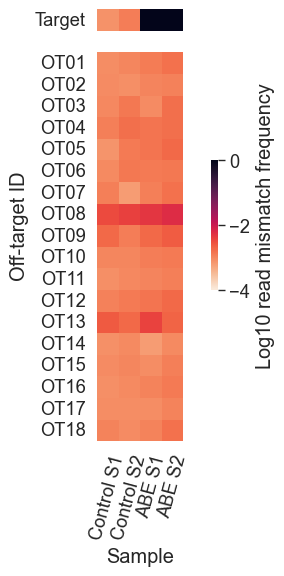

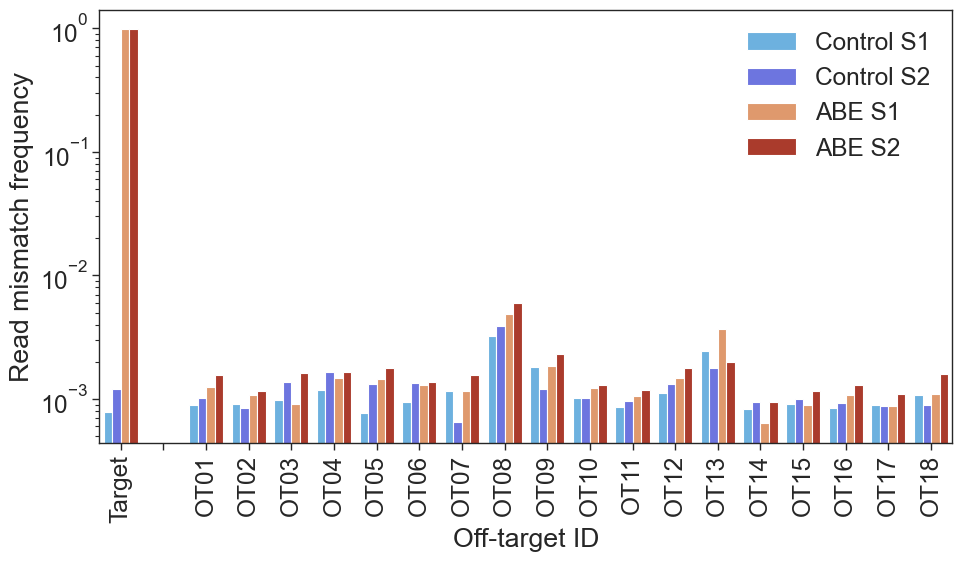

In [5]:
# Mini-heatmap of frequencies in candidate offtarget list
for sample in samples:
    heatmap_values = []
    yticklabels = []
    for _, row in offtarget_df_dict[sample].iterrows():
        contig, target, strand, start, end, matched, offtarget_id = row['contig'], row['target'], row['strand'], row['start']-1, row['end'], row['matched'], row['offtarget_id']
        # Filter DF to reference positions corresponding to potential off-target
        ref_id = int(contig.split('_')[-1])-1
        slice_df = merged_df_dict[sample].loc[(merged_df_dict[sample]['ref_id'] == ref_id) & (merged_df_dict[sample]['ref_pos'] >= start) & (merged_df_dict[sample]['ref_pos'] < end)]
        
        max_log10_mut_freq = {}
        for i, (index, dfrow) in enumerate(slice_df.iterrows()):
            # verify that the filtered DF corresponds to the expected sequence
            assert (strand == '+' and str(dfrow['ref_nt']) == matched[i]) or (strand == '-' and str(dfrow['ref_nt']) == rev_comp[matched[-i-1]]), f"{contig} {strand} {start} {end} {matched}\n{''.join(slice_df['ref_nt'])}"
            for cond, rep in itertools.product(exp_conditions, exp_repeats):
                freq = dfrow[f"log10_mut_freq_{cond}_{rep}"]
                # keep max per-sample frequency across whole sequence
                try:
                    if max_log10_mut_freq[(cond, rep)] < freq:
                        max_log10_mut_freq[(cond, rep)] = freq
                except KeyError:
                    max_log10_mut_freq[(cond, rep)] = freq
        
        # add 4 columns with max per-sample frequency across whole sequence
        row_values = [max_log10_mut_freq[(cond, rep)] for cond, rep in itertools.product(exp_conditions, exp_repeats)]

        # intended target: make sure it appears first
        if target[:-3] == matched[:-3]:
            heatmap_values.insert(0, row_values)
            yticklabels.insert(0, 'Target')
        else:
            heatmap_values.append(row_values)
            yticklabels.append(f"OT{str(offtarget_id).zfill(2)}")

    # trick to separate data with white space in seaborn heatmap
    heatmap_values.insert(1, 4*[np.nan])
    yticklabels.insert(1, '')

    sns.set_theme(context='paper', style='white', font_scale=1.5, font='sans-serif')
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(
        heatmap_values,
        annot=None,
        fmt='',
        cmap='rocket_r',
        vmin=-4,
        vmax=0,
        xticklabels=[f"{cond} {rep}" for cond, rep in itertools.product(exp_conditions, exp_repeats)],
        yticklabels=yticklabels,
        square=True,
        cbar=True,
        cbar_kws={"shrink": .3, 'location': 'right', 'label': 'Log10 read mismatch frequency'},
    )
    ax.set(xlabel="Sample", ylabel="Off-target ID")
    ax.tick_params(left=False, bottom=False)
    plt.xticks(rotation=75)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/{sample}_mini-hm.png", dpi=300, format='png')
    plt.savefig(f"{PLOTS_DIR}/{sample}_mini-hm.svg", dpi=300, format='svg')
    plt.savefig(f"{PLOTS_DIR}/{sample}_mini-hm.pdf", dpi=300, format='pdf')

    # Bar plot version
    barplot_data = []
    cond_rep_list = [f"{cond} {rep}" for cond, rep in itertools.product(exp_conditions, exp_repeats)]
    for idx, row_values in enumerate(heatmap_values):
        for cond_rep_idx, value in enumerate(row_values):
            cond_rep = cond_rep_list[cond_rep_idx]
            offtarget_id = yticklabels[idx]
            barplot_data.append([offtarget_id, cond_rep, 10**value])
    df = pd.DataFrame(barplot_data, columns=['Off-target ID', 'Sample', 'Read mismatch frequency'])

    sns.set_theme(context='paper', style='ticks', font_scale=2, font='sans-serif')
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Off-target ID', y='Read mismatch frequency', hue='Sample', data=df, palette=[colors_dict[(cond, rep)] for cond, rep in itertools.product(exp_conditions, exp_repeats)])
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/{sample}_mini-bar.png", dpi=300, format='png')
    plt.savefig(f"{PLOTS_DIR}/{sample}_mini-bar.svg", dpi=300, format='svg')
    plt.savefig(f"{PLOTS_DIR}/{sample}_mini-bar.pdf", dpi=300, format='pdf')

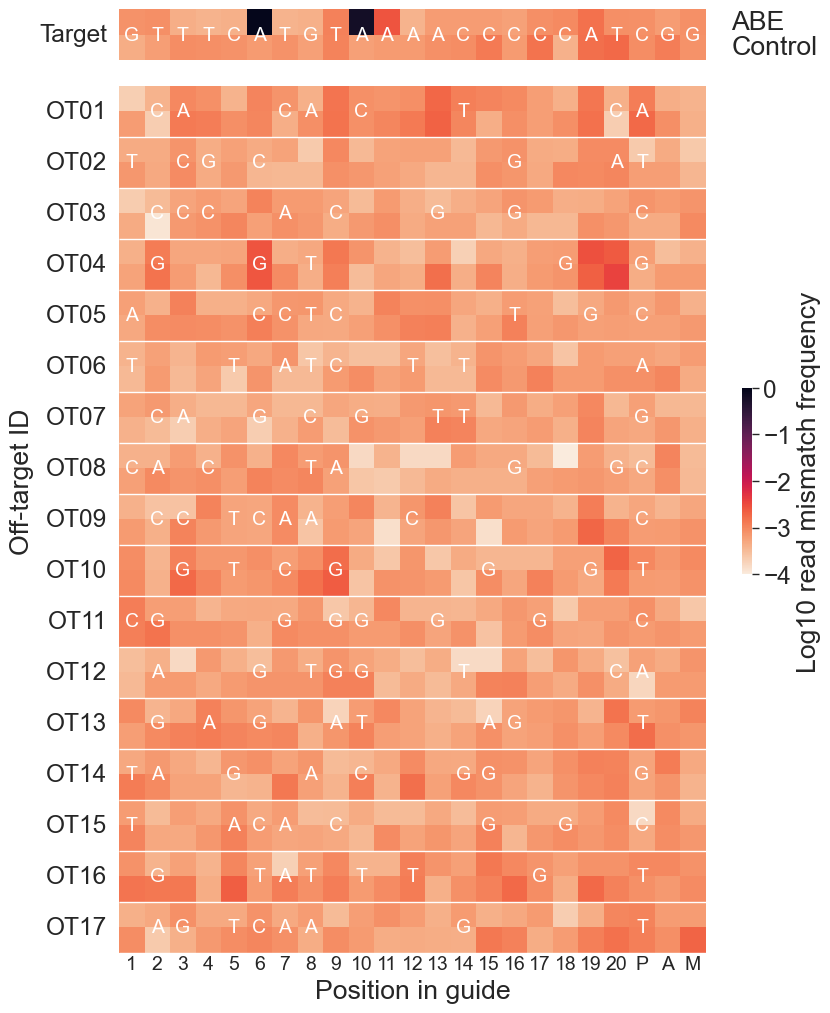

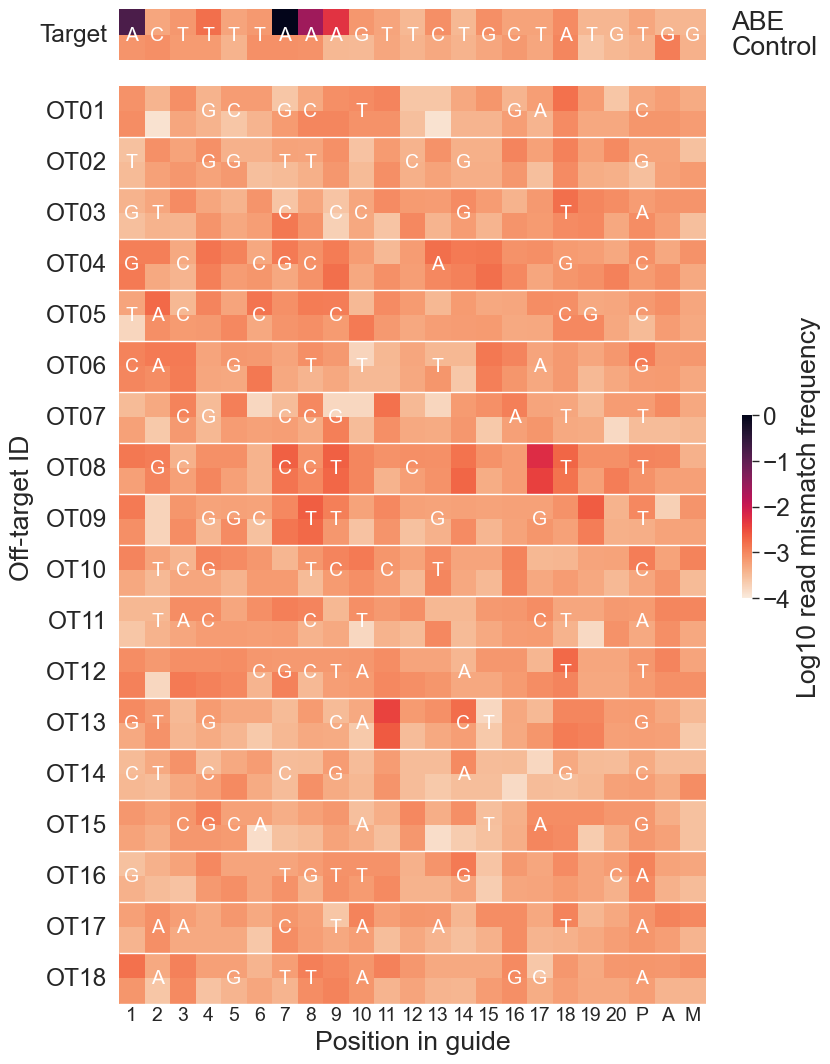

In [6]:
# Heatmap of frequencies in candidate offtarget list
for sample in samples:
    heatmap_values = []
    heatmap_labels = []
    yticklabels = []
    sort_helper_list = []
    j = 0

    for _, row in offtarget_df_dict[sample].iterrows():
        contig, target, strand, start, end, matched, offtarget_id = row['contig'], row['target'], row['strand'], row['start']-1, row['end'], row['matched'], row['offtarget_id']
        # Filter DF to reference positions corresponding to potential off-target
        ref_id = int(contig.split('_')[-1])-1
        slice_df = merged_df_dict[sample].loc[(merged_df_dict[sample]['ref_id'] == ref_id) & (merged_df_dict[sample]['ref_pos'] >= start) & (merged_df_dict[sample]['ref_pos'] < end)]
        # Filter out candidates with mismatches in PAM or with >2 mismatches in the 10 PAM-proximal nucleotides
        if matched[-2:] != 'GG' or sum(p!=m for p, m in zip(target[10:20], matched[10:20])) > 2:
            continue
        # Filter DF to reference positions corresponding to potential off-target
        ref_id = int(contig.split('_')[-1])-1
        slice_df = merged_df_dict[sample].loc[(merged_df_dict[sample]['ref_id'] == ref_id) & (merged_df_dict[sample]['ref_pos'] >= start) & (merged_df_dict[sample]['ref_pos'] < end)]
        
        row_values_ctrl = []
        row_values_abe = []
        max_log10_mut_freq = {}
        i = 0
        for index, dfrow in slice_df.iterrows():
            # verify that the filtered DF corresponds to the expected sequence
            assert (strand == '+' and str(dfrow['ref_nt']) == matched[i]) or (strand == '-' and str(dfrow['ref_nt']) == rev_comp[matched[-i-1]])
            # save maximum frequency at every position out of the 2 repeats
            row_values_ctrl.append(max(dfrow["log10_mut_freq_Control_S1"], dfrow["log10_mut_freq_Control_S2"]))
            row_values_abe.append(max(dfrow["log10_mut_freq_ABE_S1"], dfrow["log10_mut_freq_ABE_S2"]))
            i += 1
        if strand == '-':
            row_values_ctrl = row_values_ctrl[::-1]
            row_values_abe = row_values_abe[::-1]

        # intended target: make sure it appears first, and print all nucleotides
        if target[:-3] == matched[:-3]:
            sort_helper_list.append(1000)
            heatmap_labels.append(list(matched))
            heatmap_labels.append(['']*len(target))
            heatmap_values.append(row_values_abe)
            heatmap_values.append(row_values_ctrl)
            yticklabels.append('Target')
        # others: sort by ID, and print only mismatches
        else:
            sort_helper_list.append(1000-j)
            heatmap_labels.append(['' if p==m else m for p, m in zip(target, matched)])
            heatmap_labels.append(['']*len(target))
            heatmap_values.append(row_values_abe)
            heatmap_values.append(row_values_ctrl)
            yticklabels.append(f"OT{str(offtarget_id).zfill(2)}")
        j += 1

    sort_idx = sorted(range(len(sort_helper_list)), key=sort_helper_list.__getitem__)[::-1]
    sorted_heatmap_values = []
    sorted_heatmap_labels = []
    sorted_yticklabels = []
    for i in sort_idx:
        sorted_heatmap_values.append(heatmap_values[2*i])
        sorted_heatmap_values.append(heatmap_values[2*i+1])
        sorted_heatmap_labels.append(heatmap_labels[2*i])
        sorted_heatmap_labels.append(heatmap_labels[2*i+1])
        sorted_yticklabels.append(yticklabels[i])
        sorted_yticklabels.append('')

    # trick to separate data with white space in seaborn heatmap
    sorted_heatmap_labels.insert(2, ['']*len(target))
    sorted_heatmap_values.insert(2, [np.nan]*len(target))
    sorted_yticklabels.insert(2, '')

    sns.set_theme(context='paper', style='white', font_scale=2, font='sans-serif')
    plt.figure(figsize=(9, 13))
    ax = sns.heatmap(
        sorted_heatmap_values,
        annot=sorted_heatmap_labels,
        annot_kws={'fontsize':14, 'color':'w'},
        fmt='',
        cmap='rocket_r',
        vmin=-4,
        vmax=0,
        square=True,
        cbar=True,
        cbar_kws={'shrink': .15, 'ticks': [0, -1, -2, -3, -4], 'location': 'right', 'label': 'Log10 read mismatch frequency'},
    )
    for t in ax.texts:
        trans = t.get_transform()
        offs = matplotlib.transforms.ScaledTranslation(0, 0.5,
                        matplotlib.transforms.IdentityTransform())
        t.set_transform(offs+trans)
    ax.text(24, 0.5, 'ABE', horizontalalignment='left', verticalalignment='center', rotation='horizontal')
    ax.text(24, 1.5, 'Control', horizontalalignment='left', verticalalignment='center', rotation='horizontal')
    ax.tick_params(left=False, bottom=False)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.hlines([2.5], *ax.get_xlim(), color='white', linewidth=16)
    ax.hlines([i*2+5 for i in range(len(sort_helper_list)-1)], *ax.get_xlim(), color='white', linewidth=1)
    plt.xticks(np.arange(23)+0.5, [str(i) for i in range(1, 21)]+['P', 'A', 'M'], rotation=0, va="center", ha="center")
    plt.yticks(np.arange(len(sorted_yticklabels))+1, sorted_yticklabels, rotation=0, va="center", ha="right")
    plt.xlabel('Position in guide')
    plt.ylabel('Off-target ID')
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/{sample}_hm.svg", format='svg')
    plt.savefig(f"{PLOTS_DIR}/{sample}_hm.pdf", format='pdf')
    plt.savefig(f"{PLOTS_DIR}/{sample}_hm.png", dpi=300, format='png')


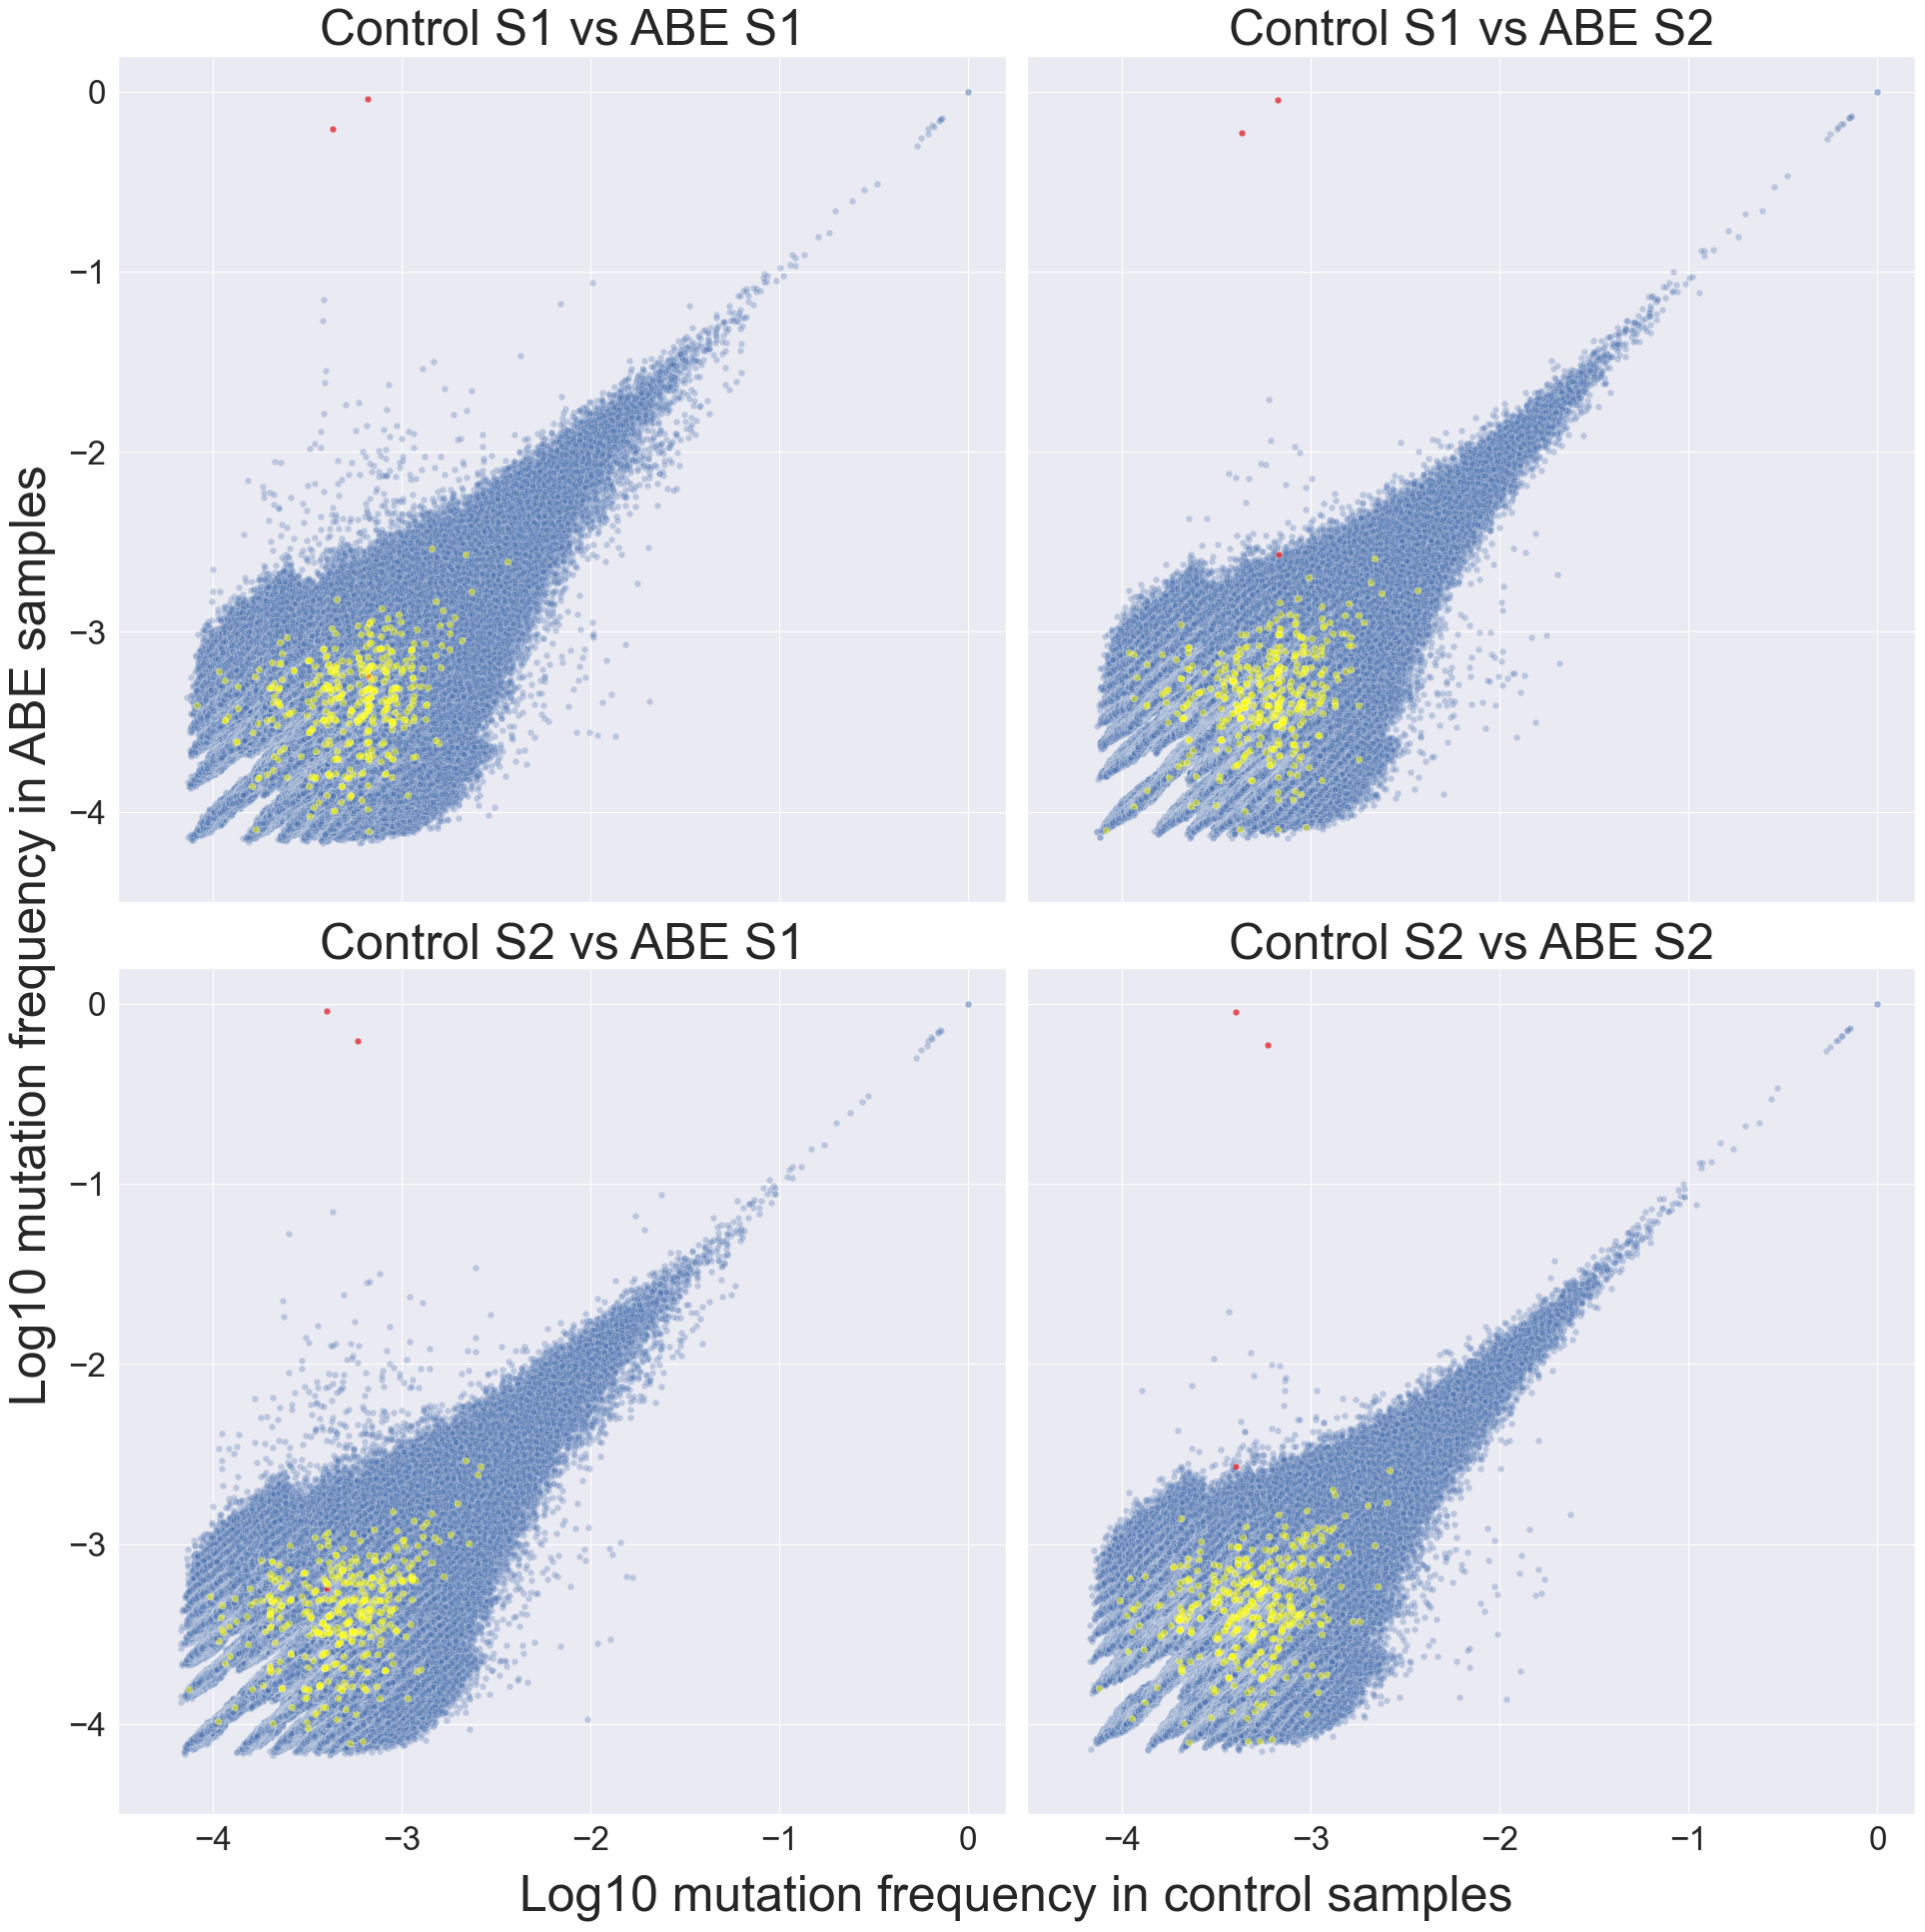

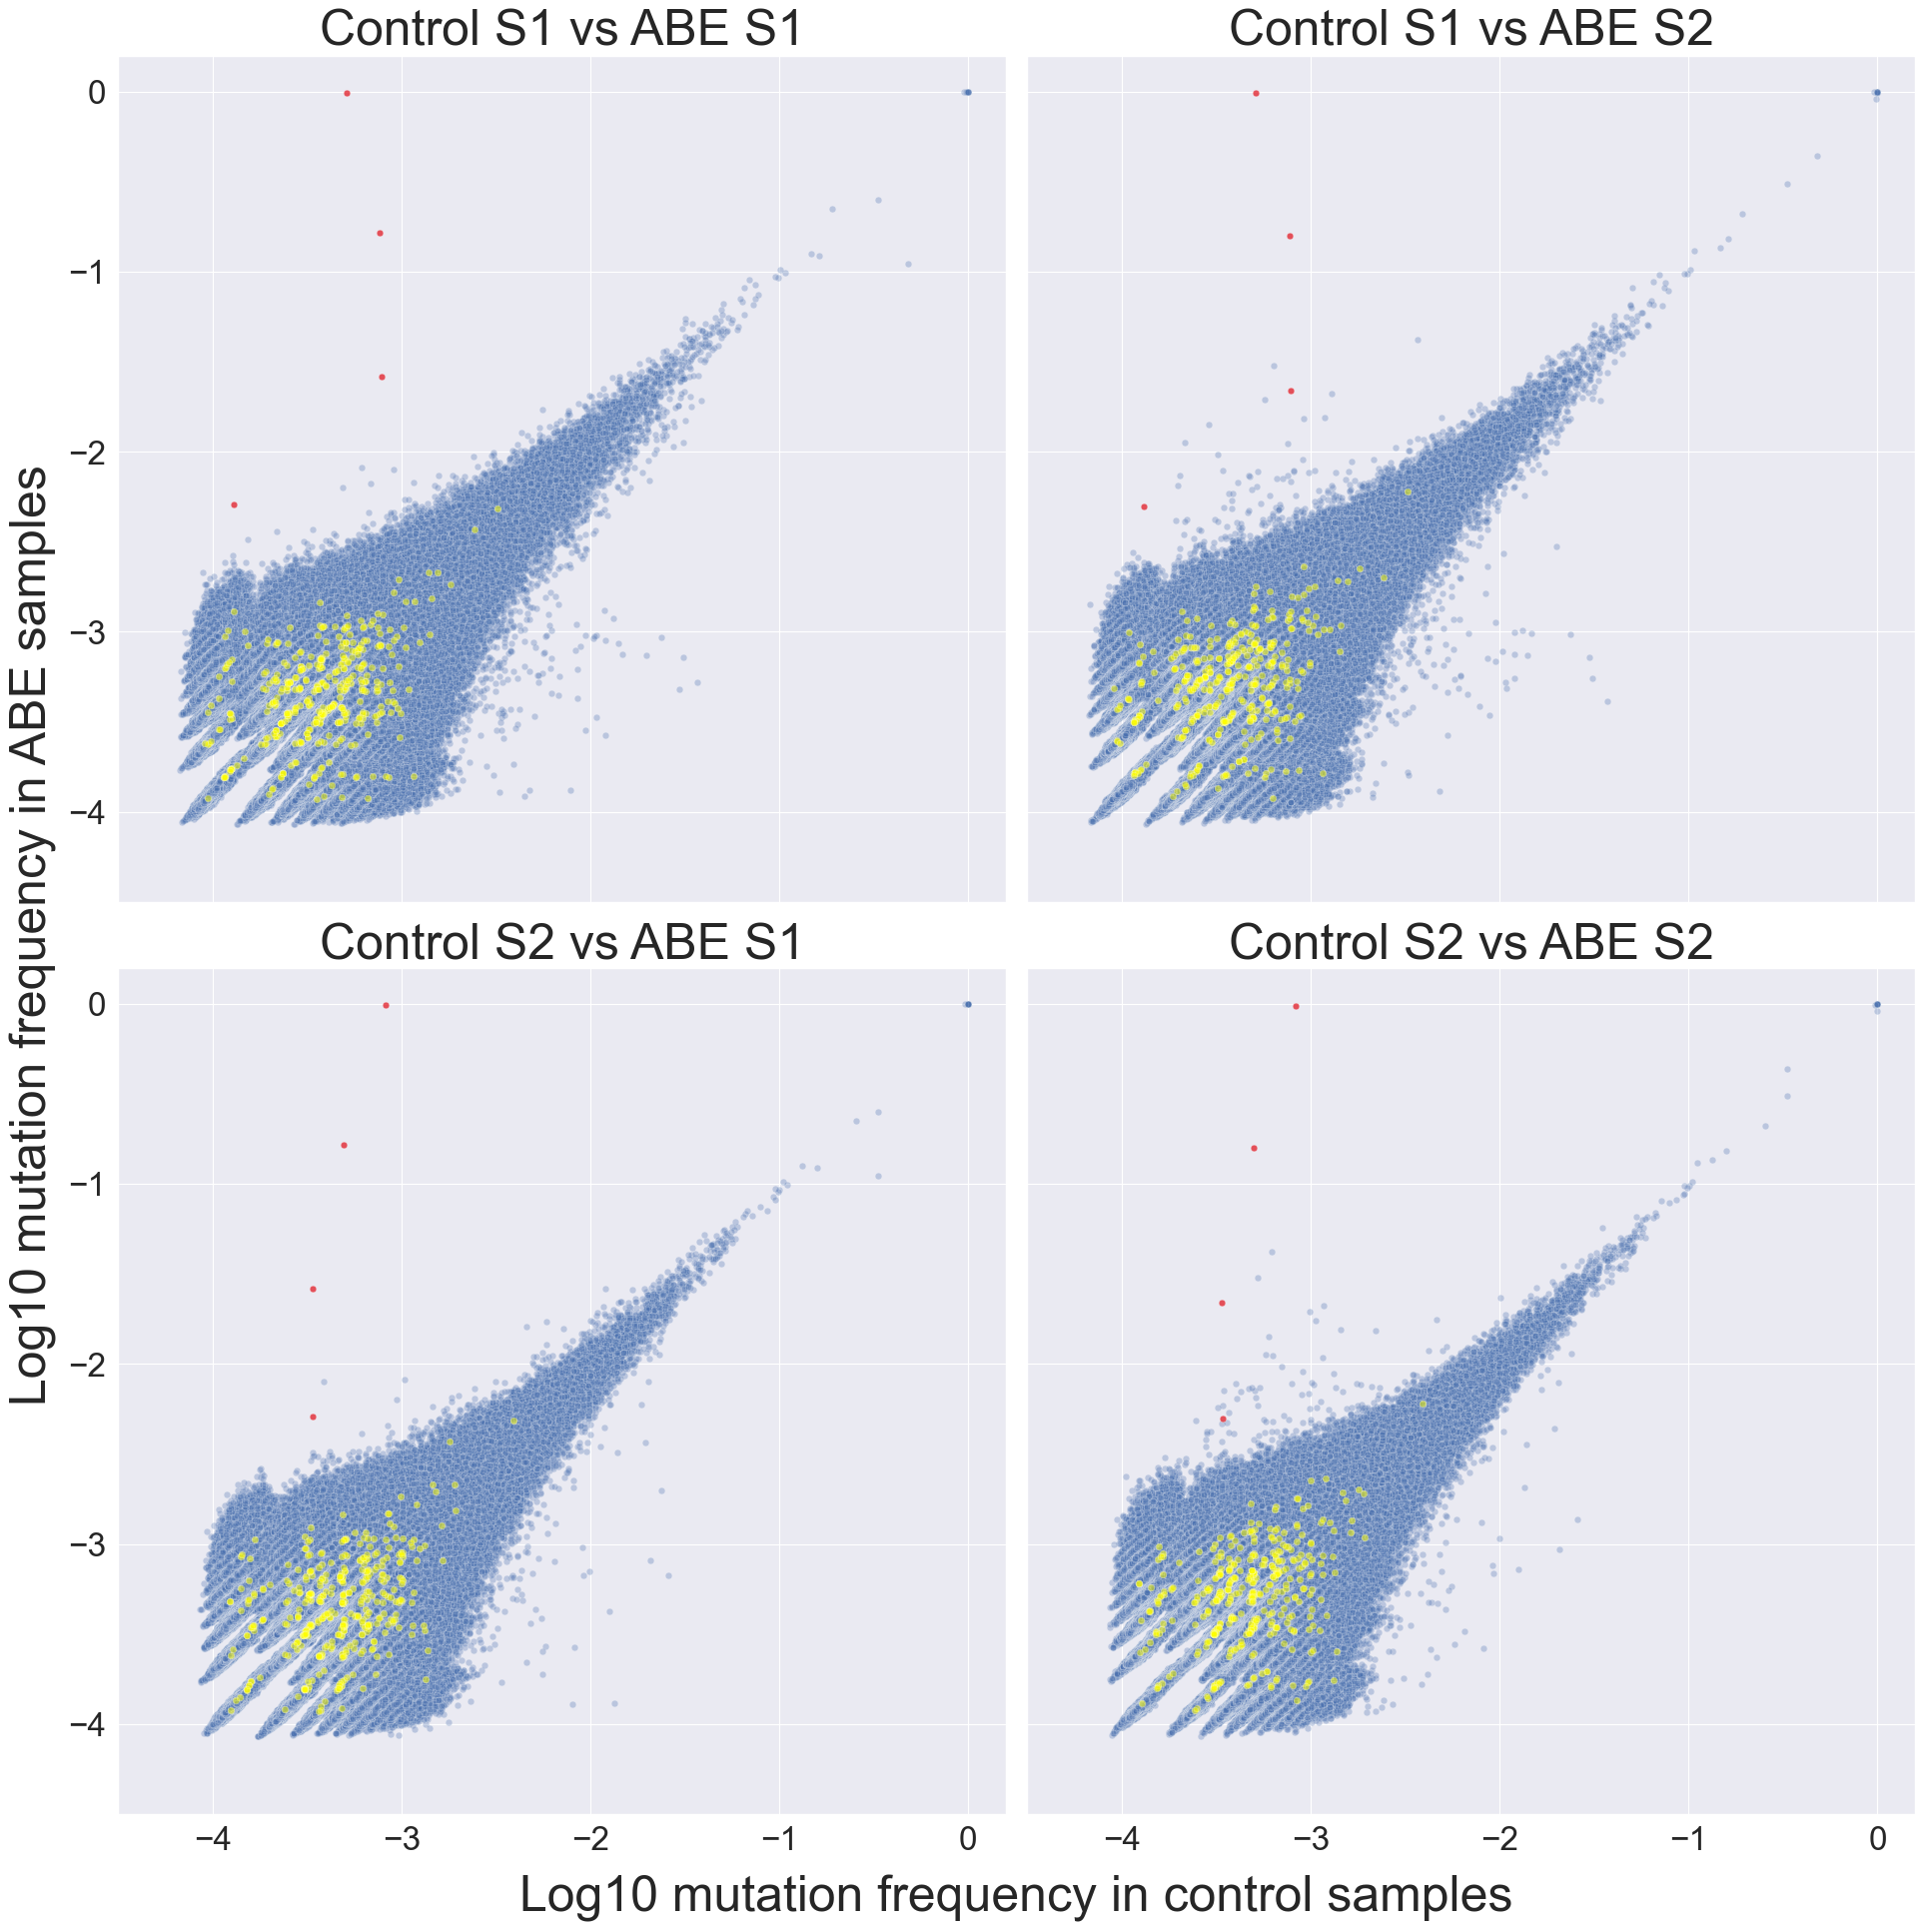

In [7]:
# Scatter plots across all genomic coordinates
sns.set_theme(context='paper', style='darkgrid', font_scale=1.5, font='sans-serif')
cond1, cond2 = exp_conditions
target_pos_dict = {
    # 2101455:2101478
    'MG1655': [2101469, 2101470, 2101471, 2101477],
    # 305630:305652
    'TN03': [305634, 305638, 305639]
}
for sample, merged_df in merged_df_dict.items():
    offtarget_pos_list = []
    for i, row in offtarget_df_dict[sample].iterrows():
        if i != 0:
            offtarget_pos_list += [j for j in range(row['start'], row['end'])]
    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(20,20))
    for i, (rep1, rep2) in enumerate(itertools.product(exp_repeats, repeat=2)):
        row = (i//2)
        col = (i%2)
        sns.scatterplot(x=merged_df[f'log10_mut_freq_{cond1}_{rep1}'], y=merged_df[f'log10_mut_freq_{cond2}_{rep2}'], alpha=0.3, ax=axs[row,col])
        target_df = merged_df.loc[merged_df.ref_pos.isin(target_pos_dict[sample])]
        sns.scatterplot(x=target_df[f'log10_mut_freq_{cond1}_{rep1}'], y=target_df[f'log10_mut_freq_{cond2}_{rep2}'], alpha=0.6, color='red', legend=False, ax=axs[row,col])
        offtarget_df = merged_df.loc[merged_df.ref_pos.isin(offtarget_pos_list)]
        sns.scatterplot(x=offtarget_df[f'log10_mut_freq_{cond1}_{rep1}'], y=offtarget_df[f'log10_mut_freq_{cond2}_{rep2}'], alpha=0.5, color='yellow', legend=False, ax=axs[row,col])
        axs[row,col].set_title(f"Control {rep1} vs ABE {rep2}", fontdict={'fontsize': 36})
        axs[row,col].set(xlim=(-4.5, 0.2), ylim=(-4.5, 0.2))
        axs[row,col].set(xlabel=None, ylabel=None)
        axs[row,col].tick_params(axis='both', which='major', labelsize=24)
        axs[row,col].tick_params(axis='both', which='minor', labelsize=24)
    # add a big axis, hide frame
    fig.add_subplot(111, frame_on=False, xticks=[], yticks=[])
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # Add labels on big axis
    plt.xlabel("Log10 mutation frequency in control samples", fontsize=36, labelpad=44)
    plt.ylabel("Log10 mutation frequency in ABE samples", fontsize=36, labelpad=44)
    plt.tight_layout()
    fig.savefig(f'{PLOTS_DIR}/{sample}_mutcorr.png', dpi=300, format='png')

In [ ]:
!mv ./plots ../../plots/offtargeting